In [442]:
import numpy
import pandas

from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, date_format, stddev
from pyspark.sql.functions import min, max, to_date
from pyspark.sql.functions import round, count, sum, when

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

spark = SparkSession.builder.appName("DataProcessingApp") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

In [443]:
df_store = spark.read.csv('stores.csv', header=True, inferSchema=True)

df_train = spark.read.csv('train.csv', header=True, inferSchema=True)

df_features =  spark.read.csv('features.csv', header=True, inferSchema=True)

df = df_train.join(df_store, "Store", "inner").join(df_features, ["Store", "Date"], "inner")

# First Look to Data and Merging Three Dataframes

In [444]:
df_train

Store,Dept,Date,Weekly_Sales,IsHoliday
1,1,2010-02-05,24924.5,false
1,1,2010-02-12,46039.49,true
1,1,2010-02-19,41595.55,false
1,1,2010-02-26,19403.54,false
1,1,2010-03-05,21827.9,false
1,1,2010-03-12,21043.39,false
1,1,2010-03-19,22136.64,false
1,1,2010-03-26,26229.21,false
1,1,2010-04-02,57258.43,false
1,1,2010-04-09,42960.91,false


In [445]:
null_counts = df_train.select(
    *[sum(when(col(c).isNull() | (col(c) == "NaN") | (col(c) == "NA"), 1).otherwise(0)).alias(c) for c in df_train.columns]
)

null_counts

Store,Dept,Date,Weekly_Sales,IsHoliday
0,0,0,0,0


In [446]:
result = df_train.groupBy('IsHoliday').agg(avg('Weekly_Sales').alias('Average_Weekly_Sales'))

result.show()

+---------+--------------------+
|IsHoliday|Average_Weekly_Sales|
+---------+--------------------+
|     true|  17035.823187350386|
|    false|  15901.445069008796|
+---------+--------------------+



<Axes: xlabel='IsHoliday', ylabel='Weekly_Sales'>

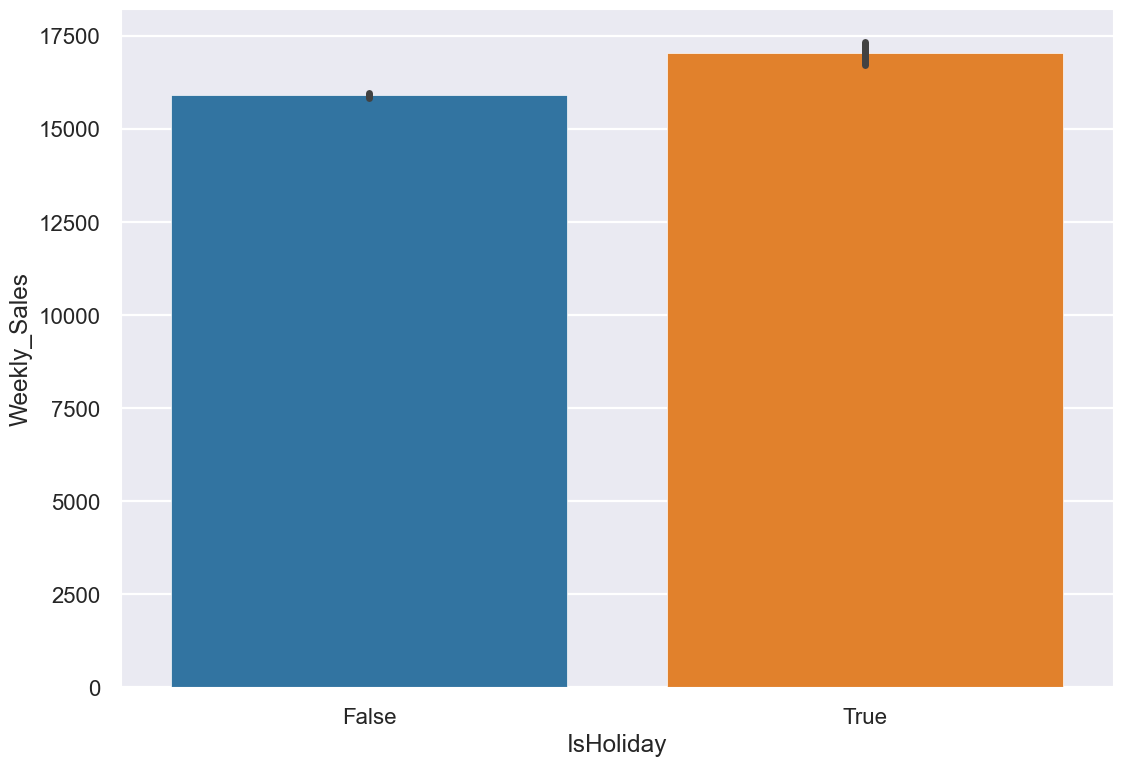

In [447]:
df_test = df_train.toPandas()
sns.barplot(x="IsHoliday", y='Weekly_Sales', data=df_test)

In [448]:
distinct_count = df.select("Store").distinct().count()
distinct_count

45

In [449]:
distinct_count = df.select("Dept").distinct().count()
distinct_count

81

In [450]:
store_dept_table = df.groupBy('Store').pivot('Dept').agg(avg('Weekly_Sales'))
store_dept_table

Store,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,54,55,56,58,59,60,65,67,71,72,74,77,78,79,80,81,82,83,85,87,90,91,92,93,94,95,96,97,98,99
31,17356.652447552446,58512.13153846153,10616.67594405594,34848.899230769246,18715.630769230764,3489.8094405594406,21012.438531468542,25277.97671328671,10815.516713286714,19911.584405594414,11583.676153846152,2800.2219580419574,42661.32062937062,17550.169999999995,8361.894755244755,8043.448671328672,5800.1208,41.546503496503526,6430.436713286709,4636.288601398601,8635.451888111893,20767.68692307692,4491.356923076919,9346.158391608395,7158.594545454547,1211.643636363636,605.2558741258744,4374.872657342658,3127.922797202798,2309.877202797202,6118.760069930071,4924.689440559442,14279.747272727274,1900.8715384615389,1459.95951048951,3032.6483216783226,80572.5283916084,NULL,56982.2662937063,1334.4918881118879,5371.462377622378,NULL,2291.057062937064,10.521212121212123,25648.204755244762,-20.261333333333333,NULL,8670.792657342654,NULL,17.722641509433966,725.6053846153844,84.19015267175571,7946.053216783217,1747.5075524475524,3305.775734265734,524.4950349650346,252.92121212121205,NULL,6633.951258741261,5743.170909090911,45999.66146853148,15344.295734265732,192.33333333333334,0.8742857142857142,36201.93860139859,19019.947902097894,25303.361888111896,18063.452097902107,8511.813076923077,1305.1941958041969,8460.688251748248,86167.26580419582,70232.13356643361,127010.11860139863,57876.20566433566,68732.14181818183,106696.01923076925,30335.294265734272,31144.97811188811,10101.886713286714,218.74220338983054
34,19947.57307692309,34916.22587412588,8377.37643356643,19791.50902097903,21633.900559440557,3419.0620279720265,18055.491608391607,27165.01314685315,17224.253496503497,16957.163566433566,15681.386993006996,5312.239300699299,23518.43986013986,10049.688461538466,16687.23496503496,6743.74986013986,5104.287723577236,29.990740740740748,2977.8260139860135,4441.242587412587,6152.82167832168,13611.64552447552,3032.286713286714,5790.00916083916,4476.318181818181,731.1102097902102,273.5554545454547,2146.3405594405594,1903.1337762237763,959.7367832167834,5010.569720279722,3464.0448251748244,8064.623916083916,1693.454335664336,883.7164335664334,2221.717412587412,48819.29181818182,NULL,38458.90993006993,407.4926760563381,4210.795594405592,NULL,3303.2736363636354,15.973400000000009,17203.738181818182,-78.91916666666667,1219.9942063492065,3965.9407692307695,NULL,27.203382352941176,1243.2427972027965,58.33669642857147,10208.866923076926,3916.4426573426554,1879.231739130435,501.3870629370631,68.41037735849055,45441.70622377621,6732.085734265735,2360.7175524475533,36636.55307692309,7516.448181818179,477.0,3.0,14997.88230769231,11687.922447552457,15840.579580419582,15730.6986013986,2838.0239860139864,1882.83048951049,6067.450629370626,44338.93678321677,34018.10223776224,67782.5209090909,29590.111328671333,37428.09692307691,69245.18797202797,19154.212307692305,17570.57748251748,7775.998181818185,347.1443243243244
28,20180.45398601399,57751.27433566434,12562.223286713295,27980.817202797207,28221.618391608397,5016.258671328671,29228.446923076925,33375.575524475506,17930.71006993008,21083.404825174843,13539.147762237762,3441.027832167834,38297.38657342657,16522.443566433572,7550.626363636366,9821.526153846155,8402.612456140349,1805.8952447552447,5695.885314685314,5153.508391608392,10210.13482517483,31939.14139860141,8328.875804195806,15434.385944055946,10936.965314685307,1525.0202797202796,561.6884615384615,5349.592517482516,3909.740419580421,2583.945034965035,8619.19230769231,8378.118391608396,17685.60230769231,2675.184615384615,1802.246013986014,1981.0533566433555,49179.48552447553,NULL,46197.60370629372,1384.8581118881123,6342.158671328671,0.75,4490.995384615384,26.11781250000002,20424.31853146853,84.146,NULL,13234.785524475526,NULL,2.3644444444444437,2645.526923076923,96.11713178294568,10960.00755244755,727.59415492957

Store numbers begin from 1 to 45, department numbers are from 1 to 99, but some numbers are missing such as there is no 88 or 89 etc. Total number of departments is 81.

From the pivot table, it is obviously seen that there are some wrong values such as there are 0 and minus values for weekly sales. But sales amount can not be minus. Also, it is impossible for one department not to sell anything whole week. So, I will change this values.

In [451]:
df_holiday = df_train.filter(col('IsHoliday') == True)
dates = df_holiday.select('Date')
unique_dates = dates.distinct()
unique_dates

Date
2010-02-12
2011-09-09
2011-11-25
2010-12-31
2011-12-30
2010-09-10
2012-09-07
2012-02-10
2011-02-11
2010-11-26


In [452]:
df_test = df_train.withColumn("Date", to_date(df_train["Date"], "yyyy-MM-dd"))

min_date = df_test.select(min("Date")).first()[0]
max_date = df_test.select(max("Date")).first()[0]

print("Start Date:", min_date)
print("End Date:", max_date)

Start Date: 2010-02-05
End Date: 2012-10-26


In [453]:
df_store

Store,Type,Size
1,A,151315
2,A,202307
3,B,37392
4,A,205863
5,B,34875
6,A,202505
7,B,70713
8,A,155078
9,B,125833
10,B,126512


In [454]:
null_counts = df_store.select(
    *[sum(when(col(c).isNull() | (col(c) == "NaN") | (col(c) == "NA"), 1).otherwise(0)).alias(c) for c in df_store.columns]
)

null_counts

Store,Type,Size
0,0,0


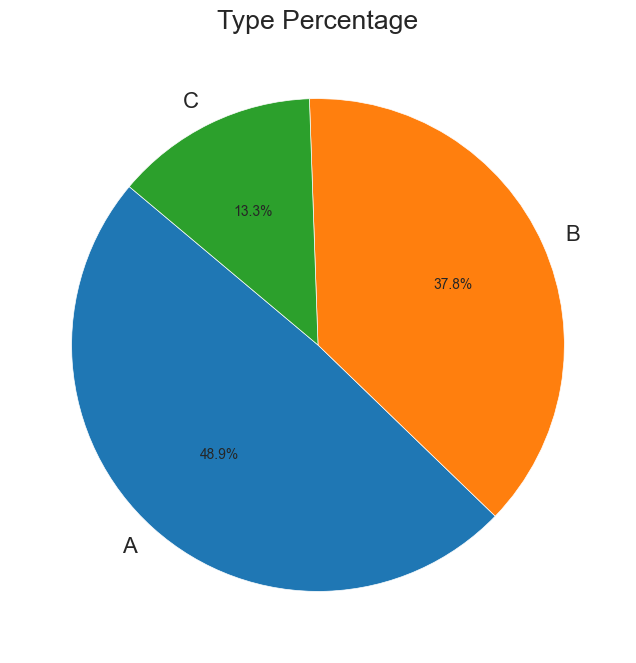

In [455]:
df_test = df_store.toPandas()

type_counts = df_test["Type"].value_counts()
total = len(df_test)

type_percentages = (type_counts / total) * 100

plt.figure(figsize=(8, 8))
plt.pie(type_percentages, labels=type_percentages.index, autopct='%1.1f%%', startangle=140)
plt.title("Type Percentage")
plt.show()

In [456]:
result = df_store.groupBy('Type').agg(
    count('Size').alias('Count'),
    round(avg('Size'), 2).alias('Mean_Size'),
    round(stddev('Size'), 2).alias('StdDev_Size'),
    round(min('Size'), 2).alias('Min_Size'),
    round(max('Size'), 2).alias('Max_Size')
)

result.select('Type', 'Count', 'Mean_Size', 'StdDev_Size', 'Min_Size', 'Max_Size').show()


+----+-----+---------+-----------+--------+--------+
|Type|Count|Mean_Size|StdDev_Size|Min_Size|Max_Size|
+----+-----+---------+-----------+--------+--------+
|   B|   17|101190.71|   32371.14|   34875|  140167|
|   C|    6| 40541.67|    1304.15|   39690|   42988|
|   A|   22|177247.73|   49392.62|   39690|  219622|
+----+-----+---------+-----------+--------+--------+



In [457]:
df_test = df.toPandas()

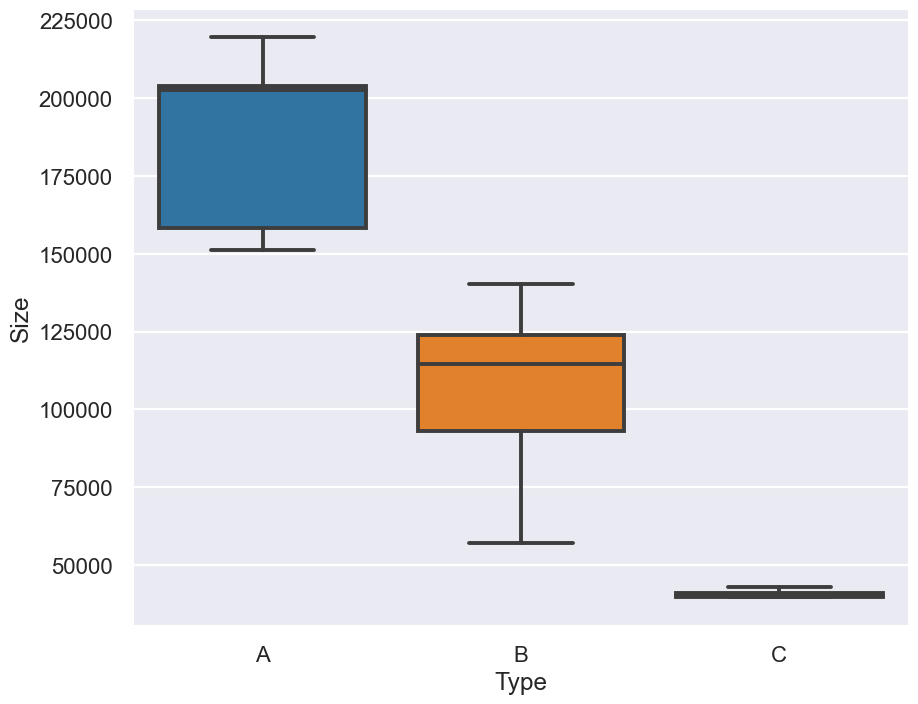

In [458]:
plt.figure(figsize=(10,8)) # To see the type-size relation
fig = sns.boxplot(x='Type', y='Size', data=df_test, showfliers=False)

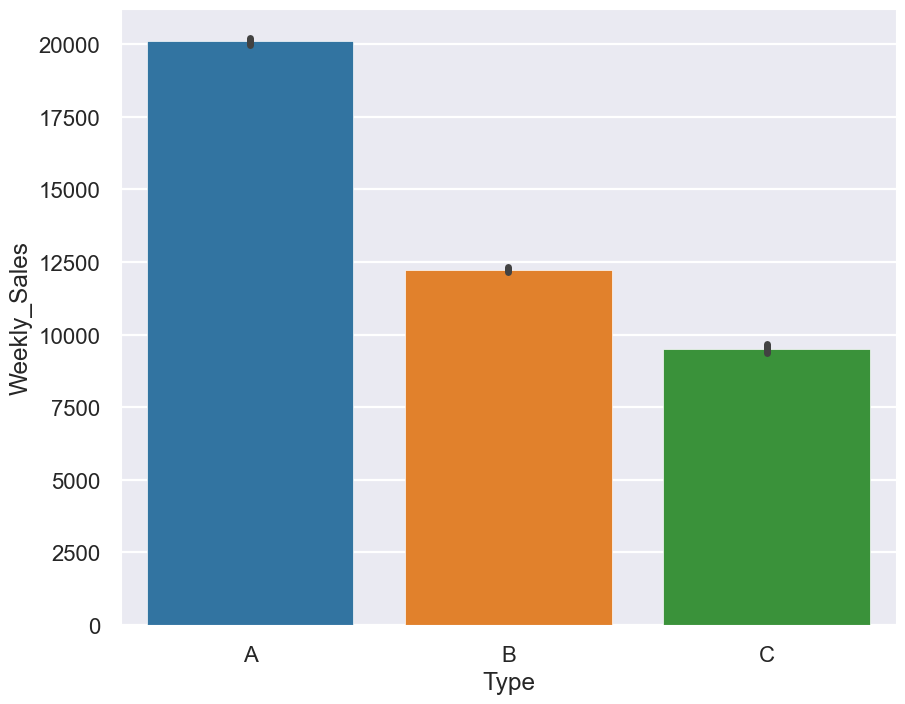

In [459]:
plt.figure(figsize=(10,8)) # To see the type-size relation
fig = sns.barplot(x='Type', y='Weekly_Sales', data=df_test)

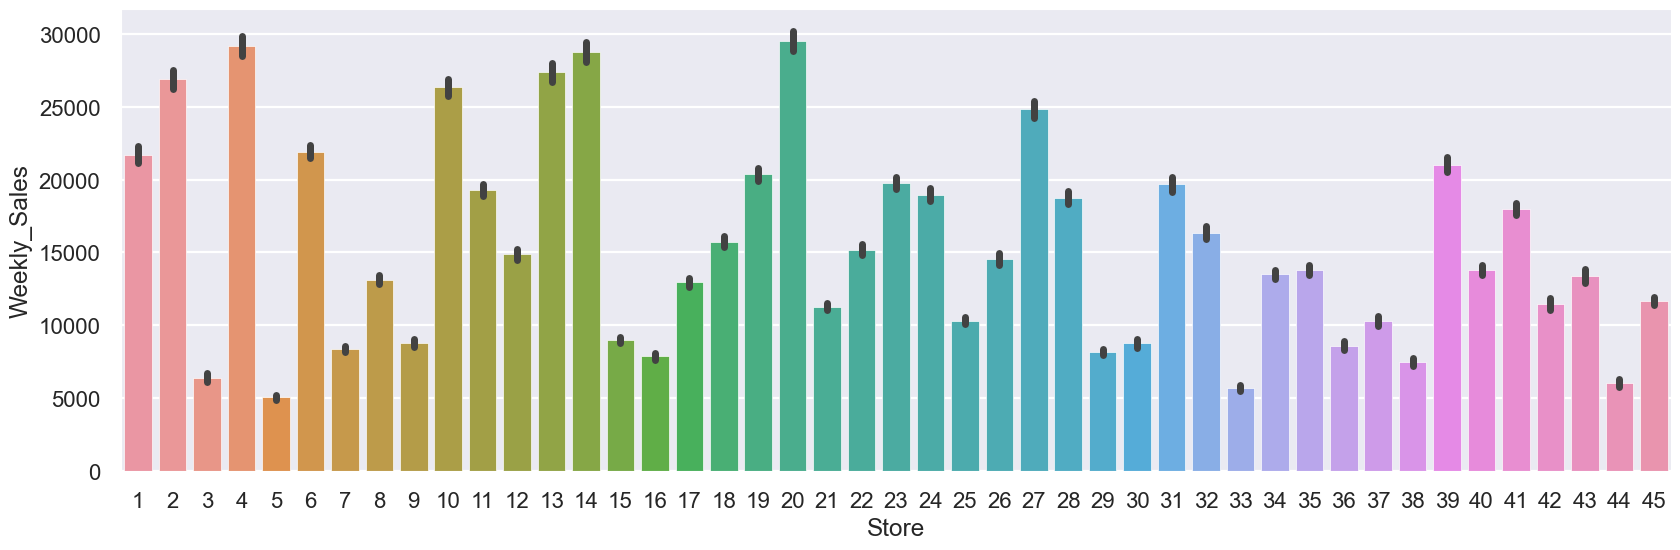

In [460]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='Store', y='Weekly_Sales', data=df_test)

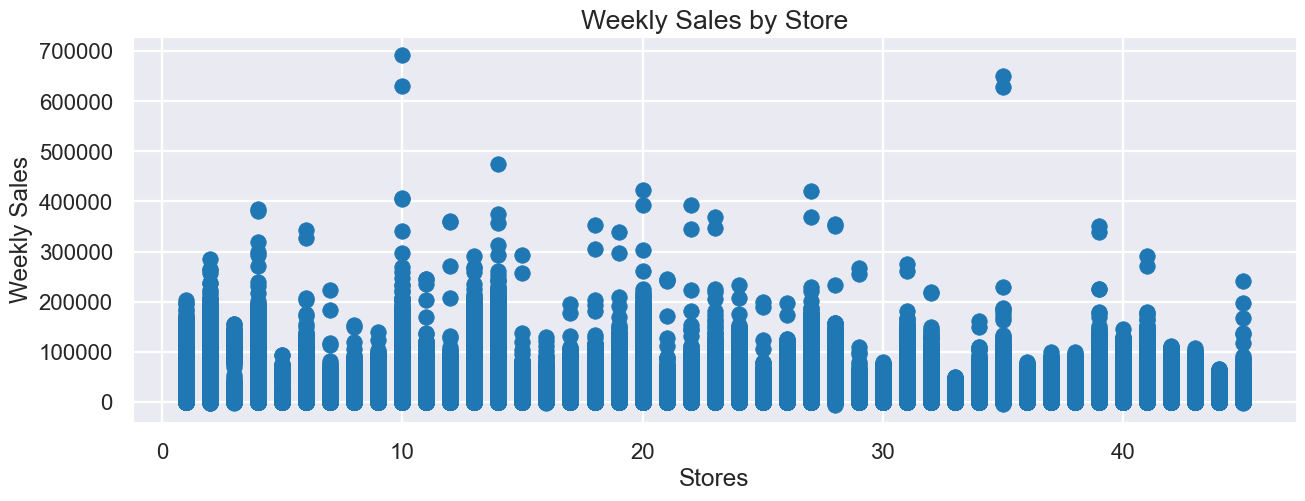

In [461]:
x = df_test['Store']
y = df_test['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Store')
plt.xlabel('Stores')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

In [462]:
df_features

Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
1,2010-02-05,42.31,2.572,NA,NA,NA,NA,NA,211.0963582,8.106,false
1,2010-02-12,38.51,2.548,NA,NA,NA,NA,NA,211.2421698,8.106,true
1,2010-02-19,39.93,2.514,NA,NA,NA,NA,NA,211.2891429,8.106,false
1,2010-02-26,46.63,2.561,NA,NA,NA,NA,NA,211.3196429,8.106,false
1,2010-03-05,46.5,2.625,NA,NA,NA,NA,NA,211.3501429,8.106,false
1,2010-03-12,57.79,2.667,NA,NA,NA,NA,NA,211.3806429,8.106,false
1,2010-03-19,54.58,2.72,NA,NA,NA,NA,NA,211.215635,8.106,false
1,2010-03-26,51.45,2.732,NA,NA,NA,NA,NA,211.0180424,8.106,false
1,2010-04-02,62.27,2.719,NA,NA,NA,NA,NA,210.8204499,7.808,false
1,2010-04-09,65.86,2.77,NA,NA,NA,NA,NA,210.6228574,7.808,false


In [463]:
null_counts = df_features.select(
    *[sum(when(col(c).isNull() | (col(c) == "NA"), 1).otherwise(0)).alias(c) for c in df_features.columns]
)

null_counts

Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,0,0,0,4158,5269,4577,4726,4140,585,585,0


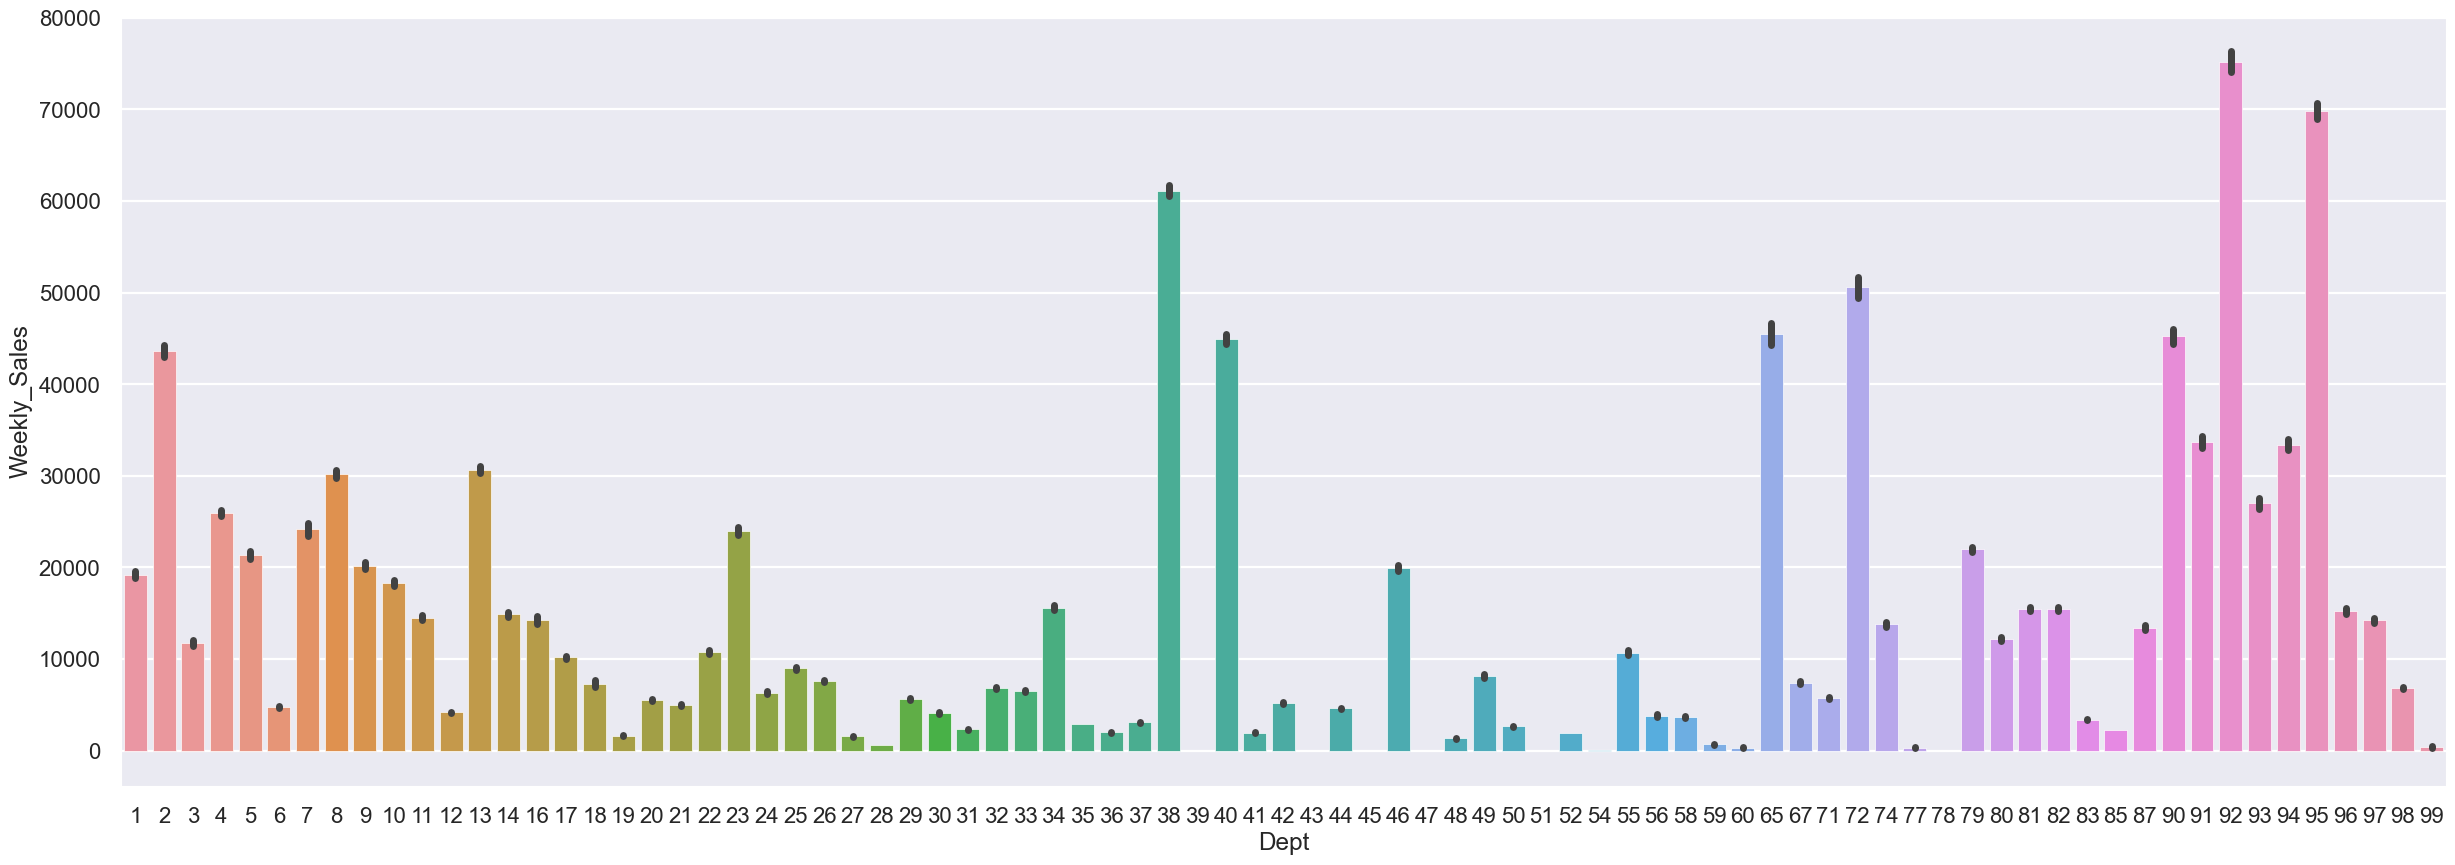

In [464]:
plt.figure(figsize=(30,10))
fig = sns.barplot(x='Dept', y='Weekly_Sales', data=df_test)

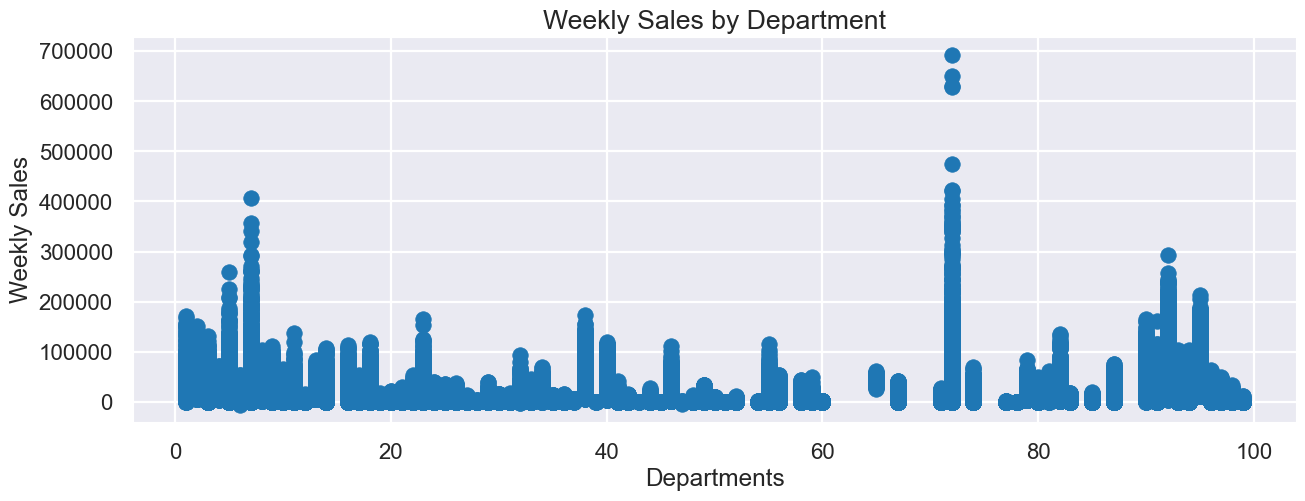

In [465]:
x = df_test['Dept']
y = df_test['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Department')
plt.xlabel('Departments')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

<Axes: xlabel='Fuel_Price'>

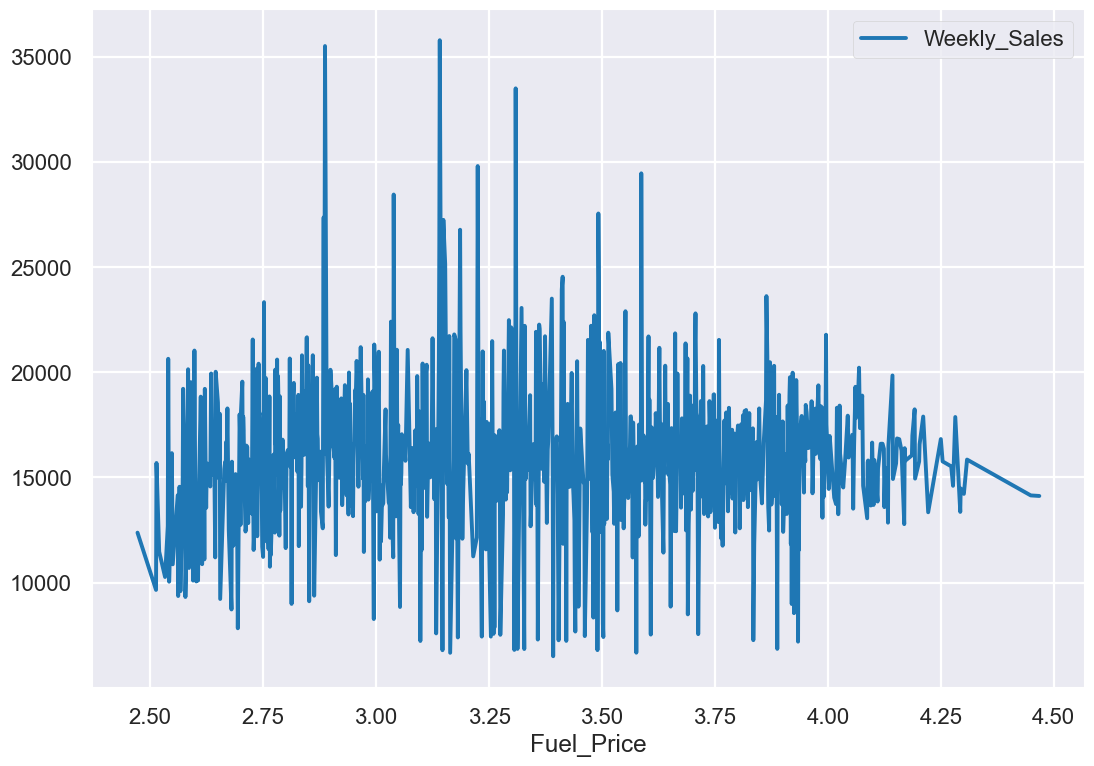

In [466]:
fuel_price = pandas.pivot_table(df_test, values = "Weekly_Sales", index= "Fuel_Price")
fuel_price.plot()

<Axes: xlabel='Temperature'>

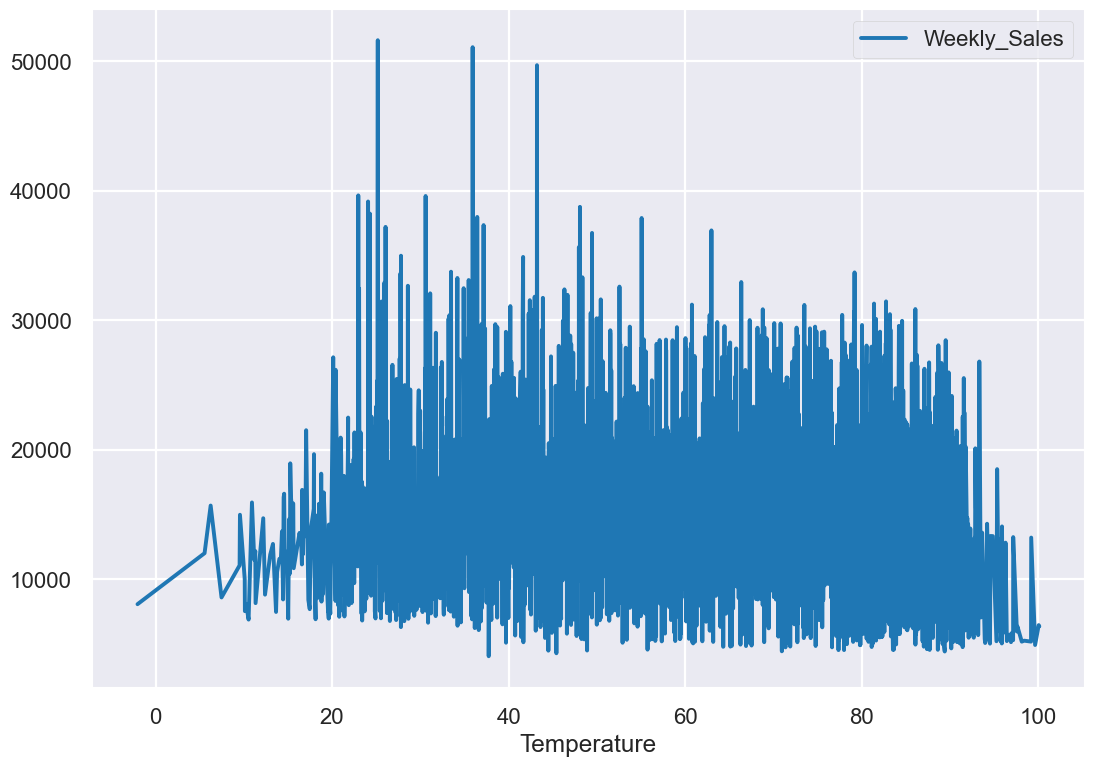

In [467]:
temp = pandas.pivot_table(df_test, values = "Weekly_Sales", index= "Temperature")
temp.plot()

<Axes: xlabel='CPI'>

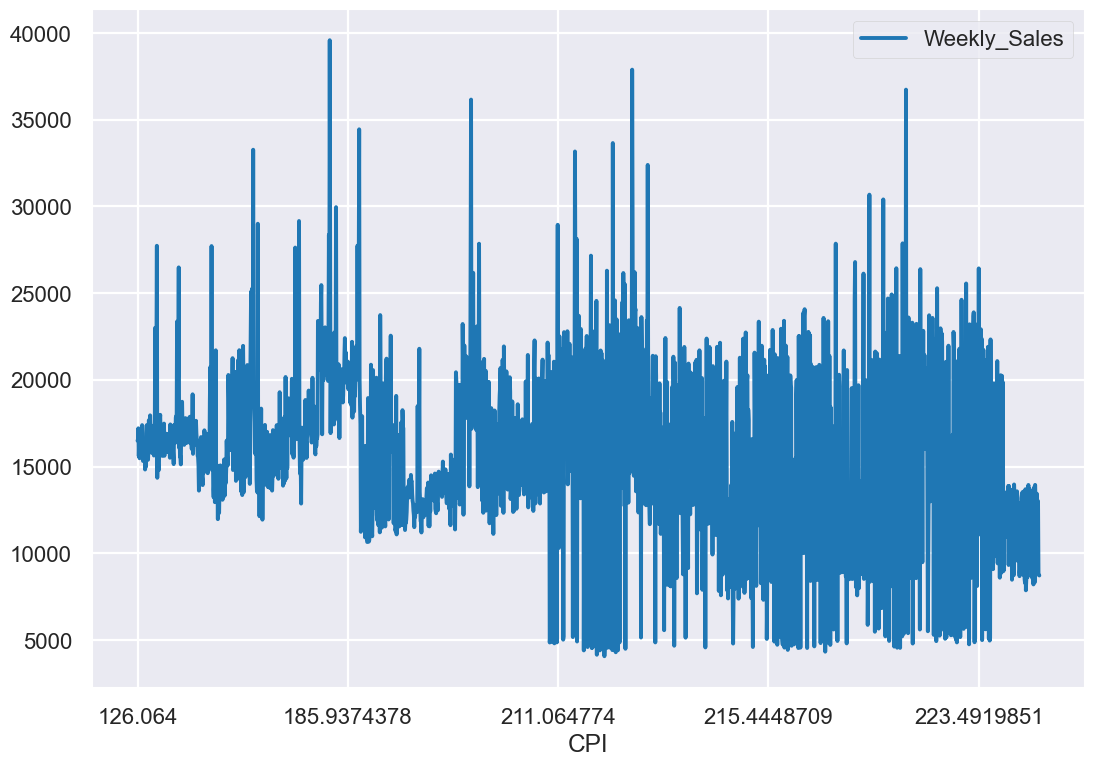

In [468]:
CPI = pandas.pivot_table(df_test, values = "Weekly_Sales", index= "CPI")
CPI.plot()

<Axes: xlabel='Unemployment'>

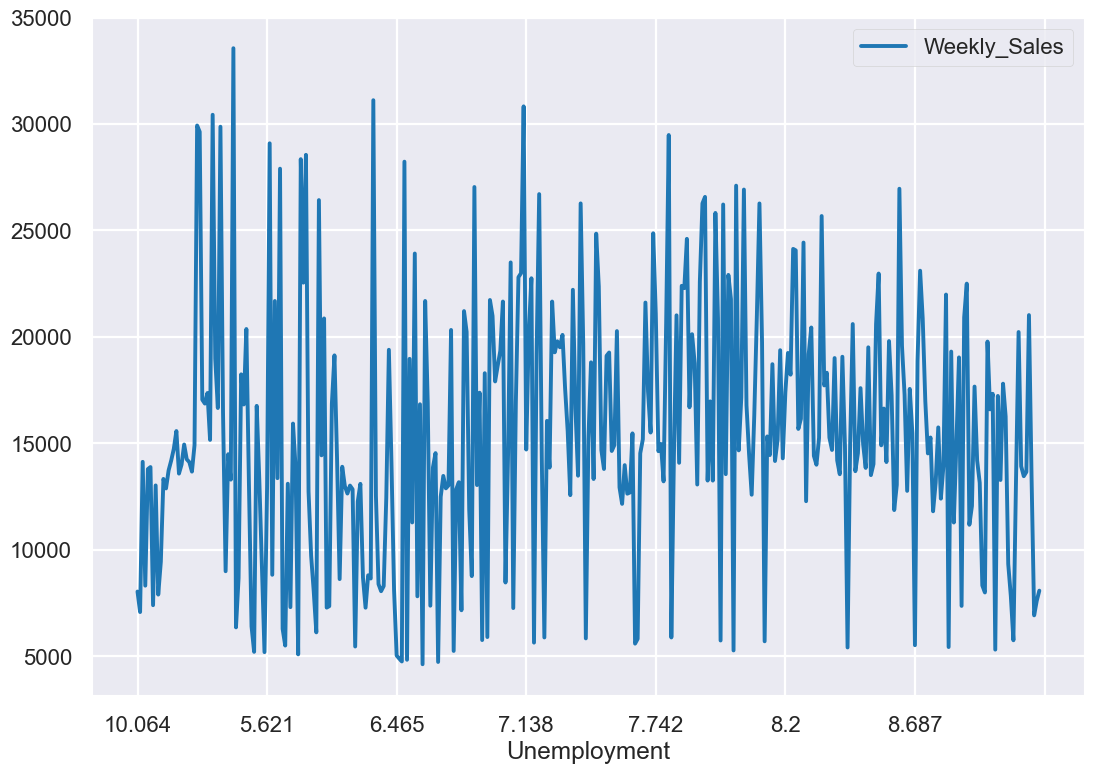

In [469]:
unemployment = pandas.pivot_table(df_test, values="Weekly_Sales", index="Unemployment")
unemployment.plot()

In [470]:
df_train = df_train.drop('ISHoliday')
df_train

Store,Dept,Date,Weekly_Sales
1,1,2010-02-05,24924.5
1,1,2010-02-12,46039.49
1,1,2010-02-19,41595.55
1,1,2010-02-26,19403.54
1,1,2010-03-05,21827.9
1,1,2010-03-12,21043.39
1,1,2010-03-19,22136.64
1,1,2010-03-26,26229.21
1,1,2010-04-02,57258.43
1,1,2010-04-09,42960.91


In [471]:
df = df_train.join(df_store, "Store", "inner").join(df_features, ["Store", "Date"], "inner")
df

Store,Date,Dept,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
1,2010-02-05,1,24924.5,A,151315,42.31,2.572,NA,NA,NA,NA,NA,211.0963582,8.106,false
1,2010-02-12,1,46039.49,A,151315,38.51,2.548,NA,NA,NA,NA,NA,211.2421698,8.106,true
1,2010-02-19,1,41595.55,A,151315,39.93,2.514,NA,NA,NA,NA,NA,211.2891429,8.106,false
1,2010-02-26,1,19403.54,A,151315,46.63,2.561,NA,NA,NA,NA,NA,211.3196429,8.106,false
1,2010-03-05,1,21827.9,A,151315,46.5,2.625,NA,NA,NA,NA,NA,211.3501429,8.106,false
1,2010-03-12,1,21043.39,A,151315,57.79,2.667,NA,NA,NA,NA,NA,211.3806429,8.106,false
1,2010-03-19,1,22136.64,A,151315,54.58,2.72,NA,NA,NA,NA,NA,211.215635,8.106,false
1,2010-03-26,1,26229.21,A,151315,51.45,2.732,NA,NA,NA,NA,NA,211.0180424,8.106,false
1,2010-04-02,1,57258.43,A,151315,62.27,2.719,NA,NA,NA,NA,NA,210.8204499,7.808,false
1,2010-04-09,1,42960.91,A,151315,65.86,2.77,NA,NA,NA,NA,NA,210.6228574,7.808,false


In [472]:
row_count = df.count()
column_count = len(df.columns)

print(f"Row Count: {row_count}")
print(f"Column Count: {column_count}")

Row Count: 421570
Column Count: 16


In [473]:
df.write.csv("iteration4.csv", header=True, mode="overwrite")

# Data Preparation

In [474]:
df = spark.read.csv("iteration4.csv", header=True, inferSchema=True)
row_count = df.count()
column_count = len(df.columns)

print(f"Row Count: {row_count}")
print(f"Column Count: {column_count}")

Row Count: 421570
Column Count: 16


In [475]:
negative_and_zero_sales = df.filter((col("Weekly_Sales") < 0) | (col("Weekly_Sales") == 0))

count_negative_and_zero_sales = negative_and_zero_sales.count()

total_count = df.count()
percentage = (count_negative_and_zero_sales / total_count) * 100

print("count_negative_and_zero_sales:", count_negative_and_zero_sales)
print("Percentage:", percentage, "%")

count_negative_and_zero_sales: 1358
Percentage: 0.3221291837654482 %


In [476]:
df = df.filter((col("Weekly_Sales") > 0))

In [477]:
sales_stats = df.describe(['Weekly_Sales'])

sales_stats.show()

+-------+------------------+
|summary|      Weekly_Sales|
+-------+------------------+
|  count|            420212|
|   mean|16033.114591372982|
| stddev| 22729.49211597351|
|    min|              0.01|
|    max|         693099.36|
+-------+------------------+



In [478]:
sorted_df = df.orderBy(col("Weekly_Sales"))

sorted_df

Store,Date,Dept,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
24,2010-10-22,99,0.01,A,203819,48.69,3.049,NA,NA,NA,NA,NA,132.8170968,8.275,false
6,2010-05-07,60,0.01,A,202505,73.68,2.835,NA,NA,NA,NA,NA,211.8442706,7.092,false
34,2012-07-27,99,0.01,A,158114,77.3,3.356,3124.08,92.22,0.36,1720.84,3878.36,130.7195806,9.285,false
8,2012-10-26,99,0.01,A,155078,64.74,3.506,2679.05,20.38,6,384.25,1691.31,227.0369359,5.124,false
39,2010-03-05,99,0.01,A,184109,50.93,2.625,NA,NA,NA,NA,NA,210.1092746,8.554,false
19,2010-02-19,99,0.01,A,203819,28.57,2.909,NA,NA,NA,NA,NA,131.637,8.35,false
39,2010-03-26,99,0.01,A,184109,54.83,2.732,NA,NA,NA,NA,NA,209.7870932,8.554,false
31,2012-05-25,99,0.01,A,203750,79.49,3.561,12146.84,NA,488.13,2066.74,5802.72,221.3828029,6.891,false
39,2010-04-23,99,0.01,A,184109,67.64,2.795,NA,NA,NA,NA,NA,209.2199574,8.464,false
20,2010-03-05,99,0.01,A,203742,31.75,2.777,NA,NA,NA,NA,NA,204.4940734,8.187,false


In [479]:
distinct_sales = df.select("Weekly_Sales").distinct()

# 使用orderBy函数按照"Weekly_Sales"列的值从小到大排序
sorted_sales = distinct_sales.orderBy("Weekly_Sales")

# 显示最小值和次小值
sorted_sales.show(1000)

+------------+
|Weekly_Sales|
+------------+
|        0.01|
|        0.02|
|        0.03|
|        0.04|
|        0.05|
|        0.06|
|        0.07|
|        0.08|
|        0.09|
|         0.1|
|        0.11|
|        0.12|
|        0.13|
|        0.14|
|        0.15|
|        0.17|
|        0.19|
|         0.2|
|        0.22|
|        0.24|
|        0.25|
|        0.27|
|        0.28|
|         0.3|
|        0.32|
|        0.33|
|        0.35|
|        0.38|
|         0.4|
|        0.44|
|        0.45|
|        0.46|
|        0.48|
|        0.49|
|         0.5|
|        0.51|
|        0.55|
|        0.56|
|        0.57|
|        0.58|
|         0.6|
|        0.61|
|        0.66|
|        0.67|
|        0.68|
|         0.7|
|        0.72|
|        0.74|
|        0.75|
|        0.76|
|        0.77|
|        0.78|
|         0.8|
|        0.82|
|        0.84|
|        0.85|
|        0.87|
|        0.88|
|         0.9|
|        0.92|
|        0.93|
|        0.94|
|        0.95|
|        0

In [480]:
df = df.na.fill(0)

In [481]:
columns_to_replace = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

for column in columns_to_replace:
    df = df.withColumn(column, when(col(column) == "NA", 0).otherwise(col(column)))


In [482]:
null_counts = df_features.select(
    *[sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df_features.columns]
)

null_counts

Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,0,0,0,0,0,0,0,0,0,0,0


All holidays are not in the data. There are 4 holiday values such as;

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13

Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13

Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13

Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13


After the 07-Sep-2012 holidays are in test set for prediction. When we look at the data, average weekly sales for holidays are significantly higher than not-holiday days. In train data, there are 133 weeks for non-holiday and 10 weeks for holiday.
I want to see differences between holiday types. So, I create new columns for 4 types of holidays and fill them with boolean values. If date belongs to this type of holiday it is True, if not False.

In [483]:
# Super Bowl dates
super_bowl_dates = ['2010-02-12', '2011-02-11', '2012-02-10']
df = df.withColumn('Super_Bowl', when(col('Date').isin(super_bowl_dates), True).otherwise(False))

# Labor Day dates
labor_day_dates = ['2010-09-10', '2011-09-09', '2012-09-07']
df = df.withColumn('Labor_Day', when(col('Date').isin(labor_day_dates), True).otherwise(False))

# Thanksgiving dates
thanksgiving_dates = ['2010-11-26', '2011-11-25']
df = df.withColumn('Thanksgiving', when(col('Date').isin(thanksgiving_dates), True).otherwise(False))

# Christmas dates
christmas_dates = ['2010-12-31', '2011-12-30']
df = df.withColumn('Christmas', when(col('Date').isin(christmas_dates), True).otherwise(False))


In [484]:
row_count = df.count()
column_count = len(df.columns)

print(f"Row Count: {row_count}")
print(f"Column Count: {column_count}")

Row Count: 420212
Column Count: 20


<Axes: xlabel='Christmas', ylabel='Weekly_Sales'>

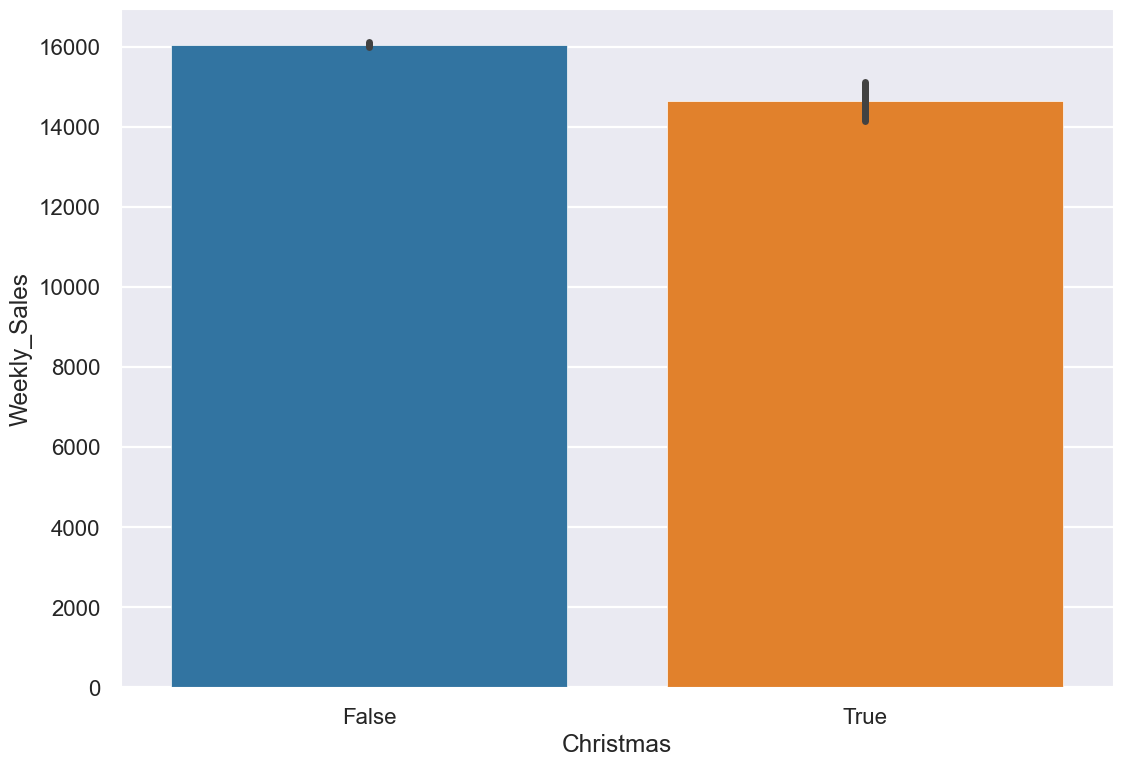

In [485]:
df_test = df.toPandas()
# Christmas holiday vs not-Christmas
sns.barplot(x='Christmas', y='Weekly_Sales', data=df_test)

<Axes: xlabel='Thanksgiving', ylabel='Weekly_Sales'>

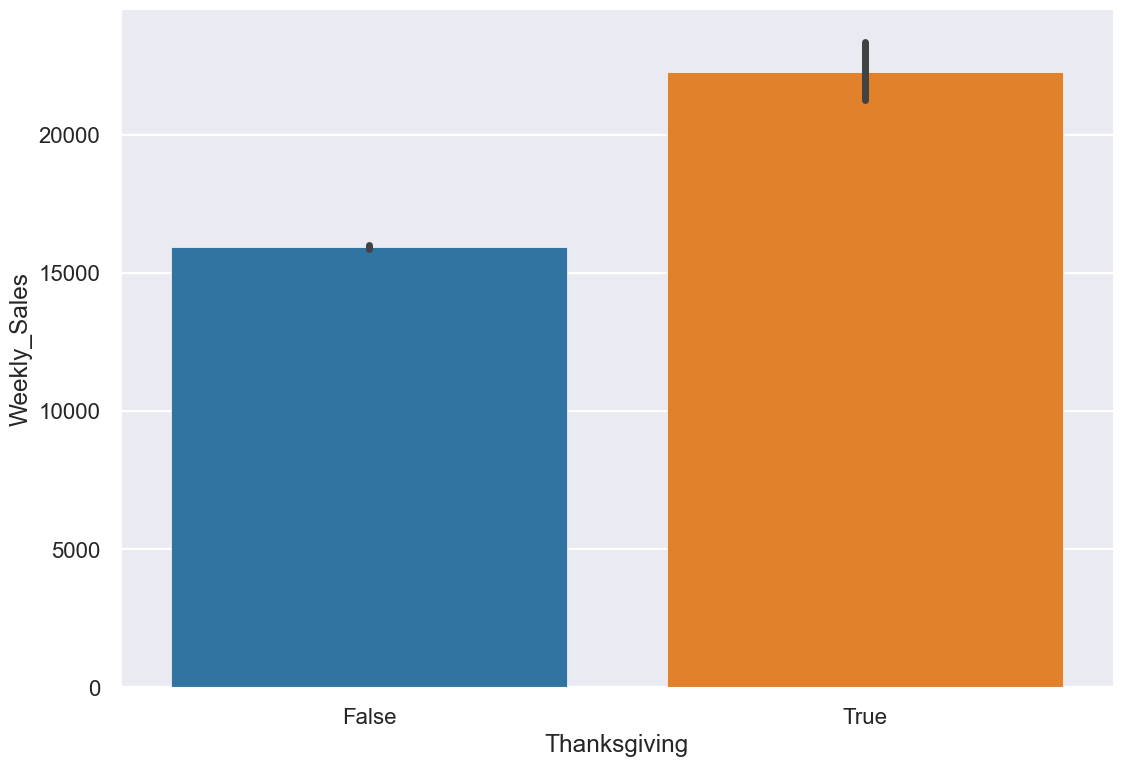

In [486]:
# Thanksgiving holiday vs not-thanksgiving
sns.barplot(x='Thanksgiving', y='Weekly_Sales', data=df_test)

<Axes: xlabel='Super_Bowl', ylabel='Weekly_Sales'>

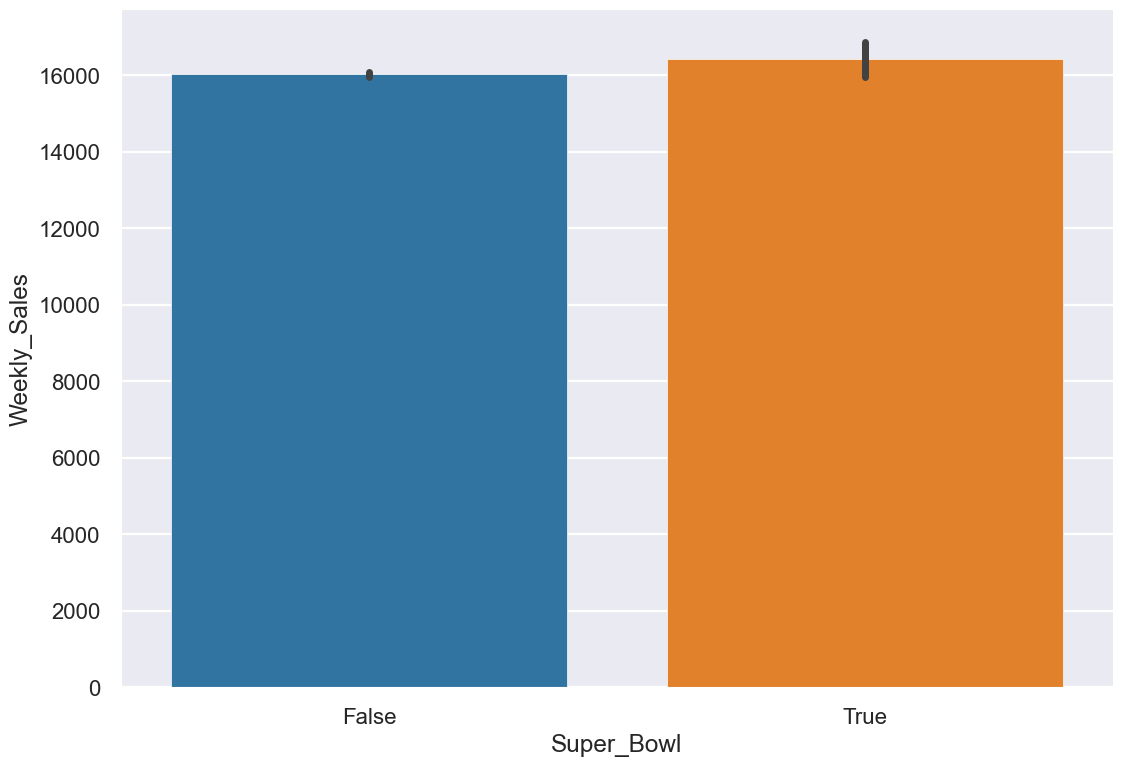

In [487]:
# Super bowl holiday vs not-super bowl
sns.barplot(x='Super_Bowl', y='Weekly_Sales', data=df_test)

<Axes: xlabel='Labor_Day', ylabel='Weekly_Sales'>

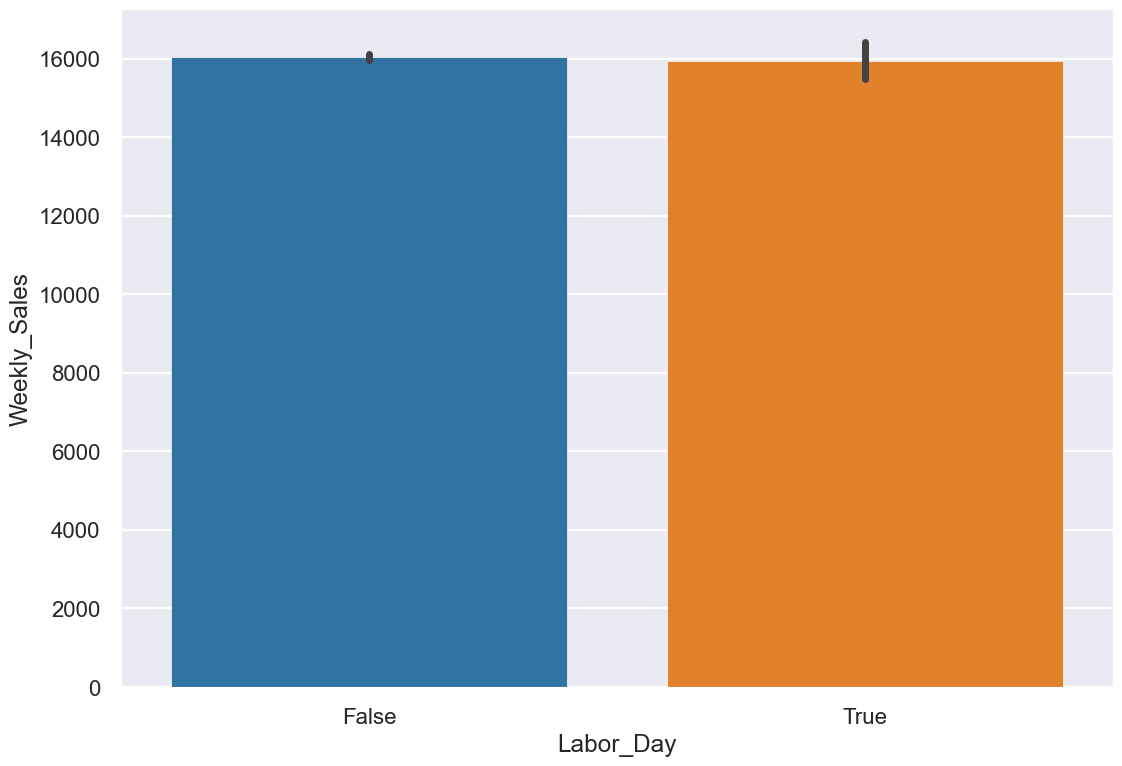

In [488]:
# Labor day holiday vs not-labor day
sns.barplot(x='Labor_Day', y='Weekly_Sales', data=df_test)

It is shown that for the graphs, Labor Day and Christmas do not increase weekly average sales. There is positive effect on sales in Super bowl, but the highest difference is in the Thanksgiving. I think, people generally prefer to buy Christmas gifts 1-2 weeks before Christmas, so it does not change sales in the Christmas week. And, there is Black Friday sales in the Thanksgiving week.

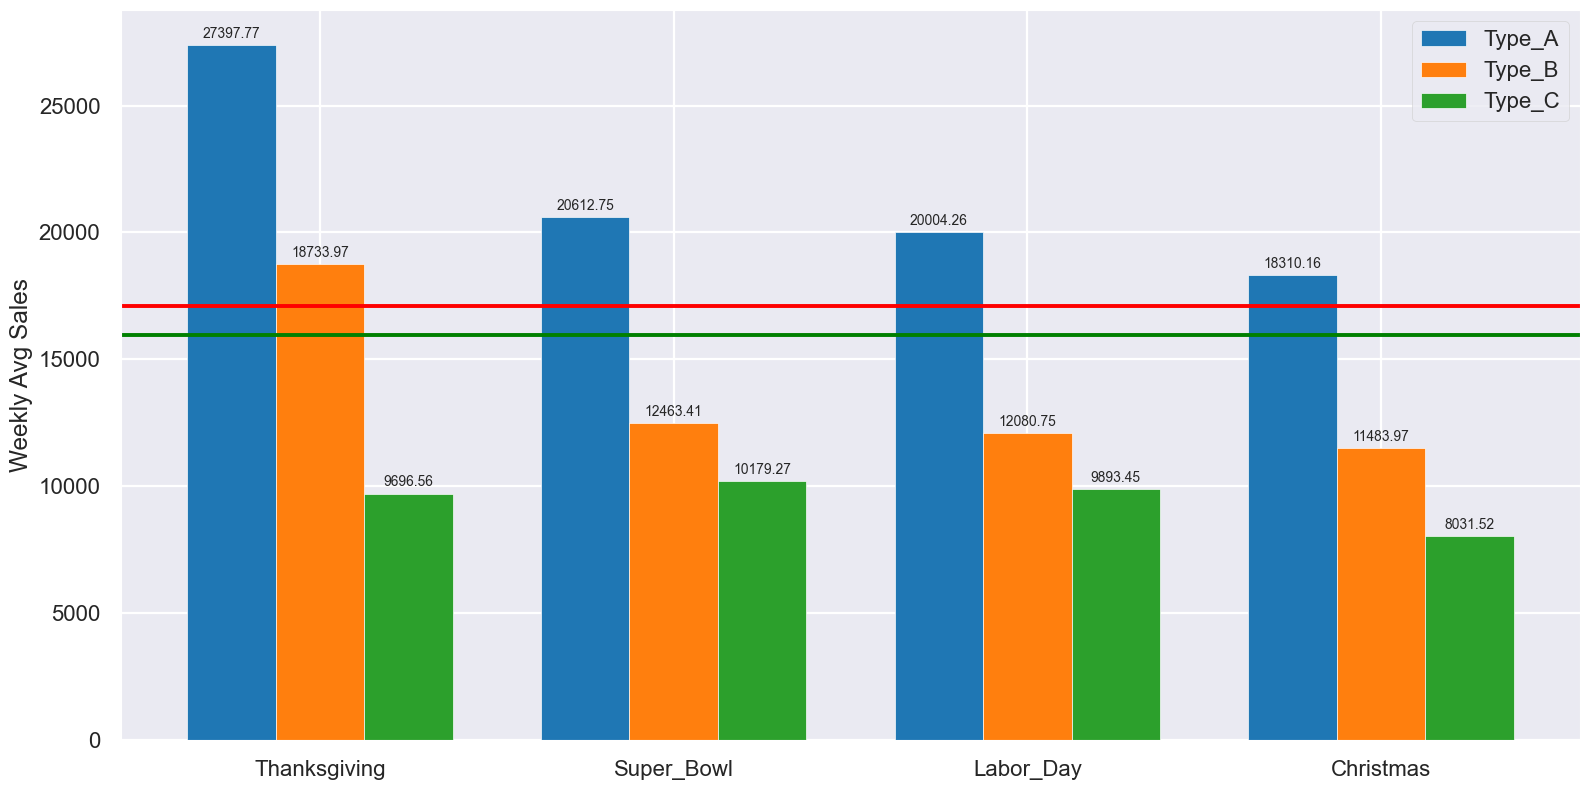

In [489]:
# Plotting avg wekkly sales according to holidays by types
plt.style.use('seaborn-poster')
labels = ['Thanksgiving', 'Super_Bowl', 'Labor_Day', 'Christmas']
A_means = [27397.77, 20612.75, 20004.26, 18310.16]
B_means = [18733.97, 12463.41, 12080.75, 11483.97]
C_means = [9696.56,10179.27,9893.45,8031.52]

x = numpy.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - width, A_means, width, label='Type_A')
rects2 = ax.bar(x , B_means, width, label='Type_B')
rects3 = ax.bar(x + width, C_means, width, label='Type_C')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Weekly Avg Sales')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.axhline(y=17094.30,color='r') # holidays avg
plt.axhline(y=15952.82,color='green') # not-holiday avg

fig.tight_layout()

plt.show()

In [490]:
top_5_sales = df.orderBy(col('Weekly_Sales').desc()).limit(5)

top_5_sales

Store,Date,Dept,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Super_Bowl,Labor_Day,Thanksgiving,Christmas
10,2010-11-26,72,693099.36,B,126512,55.33,3.162,0,0,0,0,0,126.6692667,9.003,true,false,false,true,false
35,2011-11-25,72,649770.18,B,103681,47.88,3.492,1333.24,0,58563.24,20.97,6386.86,140.4217857,8.745,true,false,false,true,false
10,2011-11-25,72,630999.19,B,126512,60.68,3.76,174.72,329,141630.61,79,1009.98,129.8364,7.874,true,false,false,true,false
35,2010-11-26,72,627962.93,B,103681,46.67,3.039,0,0,0,0,0,136.6895714,8.763,true,false,false,true,false
14,2010-11-26,72,474330.1,A,200898,46.15,3.039,0,0,0,0,0,182.7832769,8.724,true,false,false,true,false


In [491]:
df = df.withColumn("Date", date_format("Date", "yyyy-MM-dd"))
df = df.withColumn("week", date_format("Date", "w"))
df = df.withColumn("month", date_format("Date", "MM"))
df = df.withColumn("year", date_format("Date", "yyyy"))
row_count = df.count()
column_count = len(df.columns)

print(f"Row Count: {row_count}")
print(f"Column Count: {column_count}")


Row Count: 420212
Column Count: 23


<Axes: xlabel='month'>

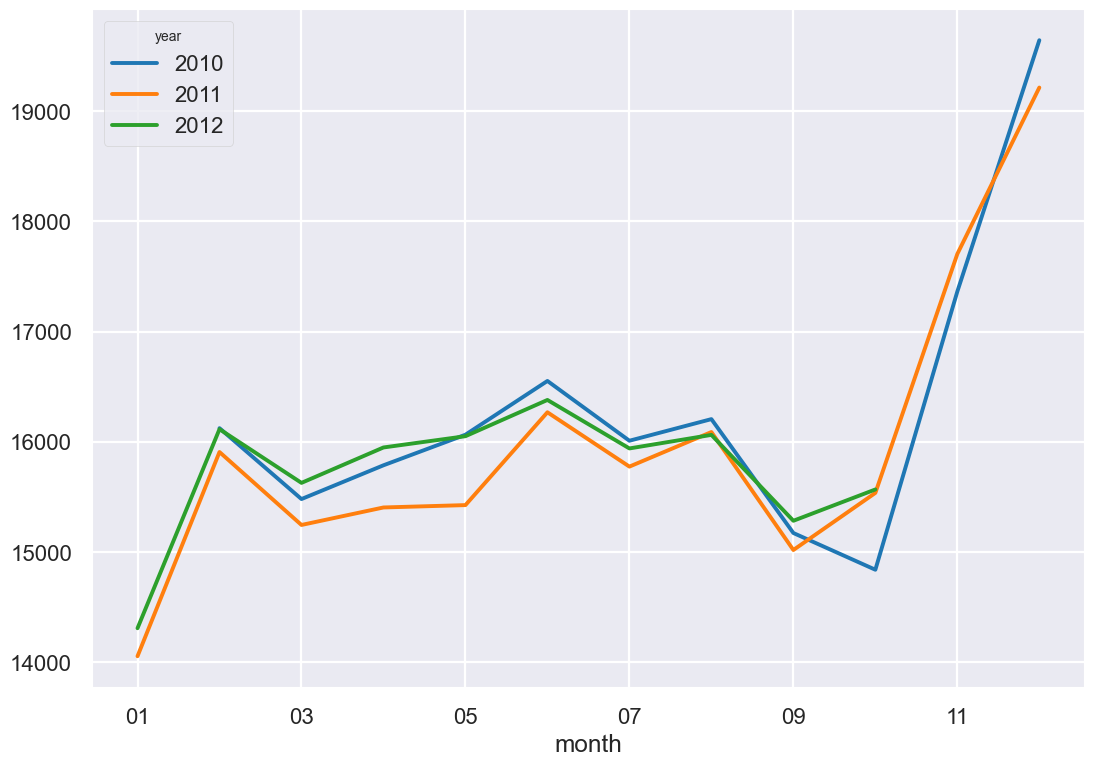

In [492]:
df_test = df.toPandas()
monthly_sales = pandas.pivot_table(df_test, values = "Weekly_Sales", columns = "year", index = "month")
monthly_sales.plot()

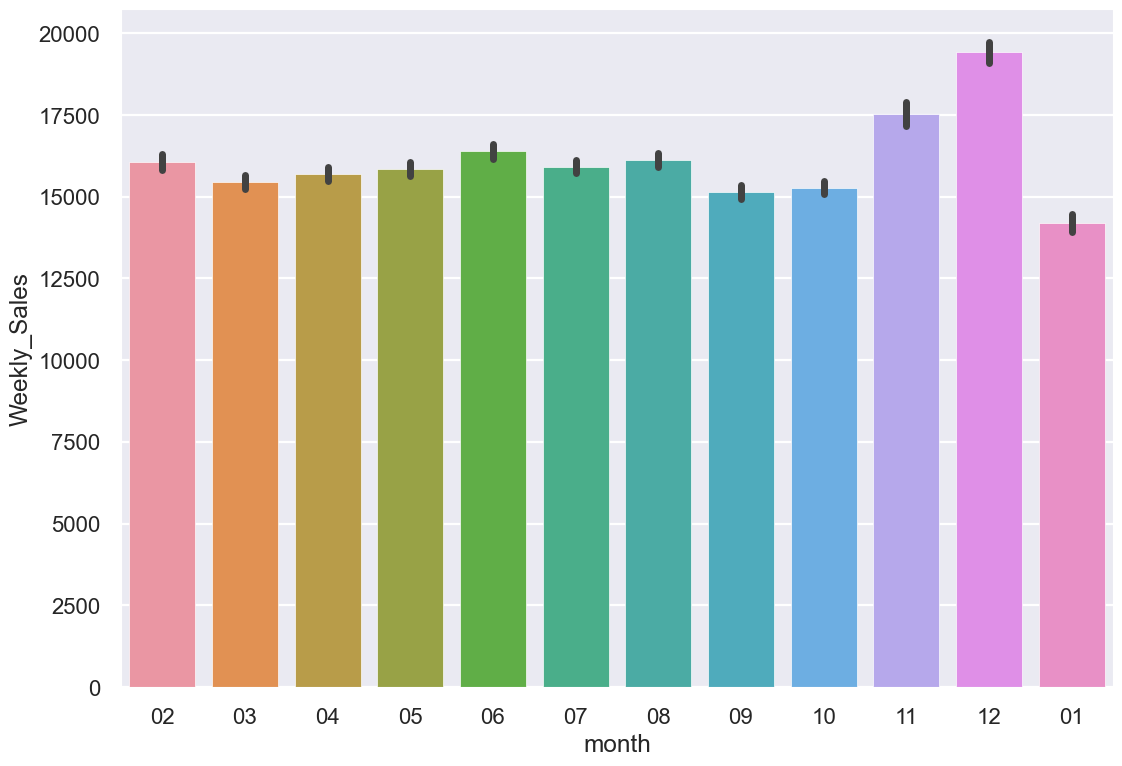

In [493]:
fig = sns.barplot(x='month', y='Weekly_Sales', data=df_test)

In [494]:
month_sales_avg = df.groupBy('month').agg(avg('Weekly_Sales').alias('avg_sales_per_month'))

sorted_month_sales = month_sales_avg.orderBy(col('avg_sales_per_month').desc())

sorted_month_sales

month,avg_sales_per_month
12,19425.798602795094
11,17534.964277405117
06,16397.60547786468
08,16113.80006886039
02,16048.701191376473
07,15905.472424939435
05,15845.556199658708
04,15696.435193273628
03,15464.817698006884
10,15279.182119454461


In [495]:
# df.write.csv("iteration4.csv", header=True, mode="overwrite")

In [496]:
# df = spark.read.csv("iteration4.csv", header=True, inferSchema=True)
# row_count = df.count()
# column_count = len(df.columns)
#
# print(f"Row Count: {row_count}")
# print(f"Column Count: {column_count}")

In [497]:
# df.show(5)

In [498]:
week_sales_avg = df.groupBy('week').agg(avg('Weekly_Sales').alias('avg_sales'))
sorted_week_sales = week_sales_avg.orderBy(col('avg_sales').desc())
top_5_week_sales = sorted_week_sales.limit(5)

top_5_week_sales

week,avg_sales
52,26454.164115577896
48,22269.601767574848
51,20478.42113388208
50,18731.794840013466
23,16982.31065363959


<Axes: xlabel='week'>

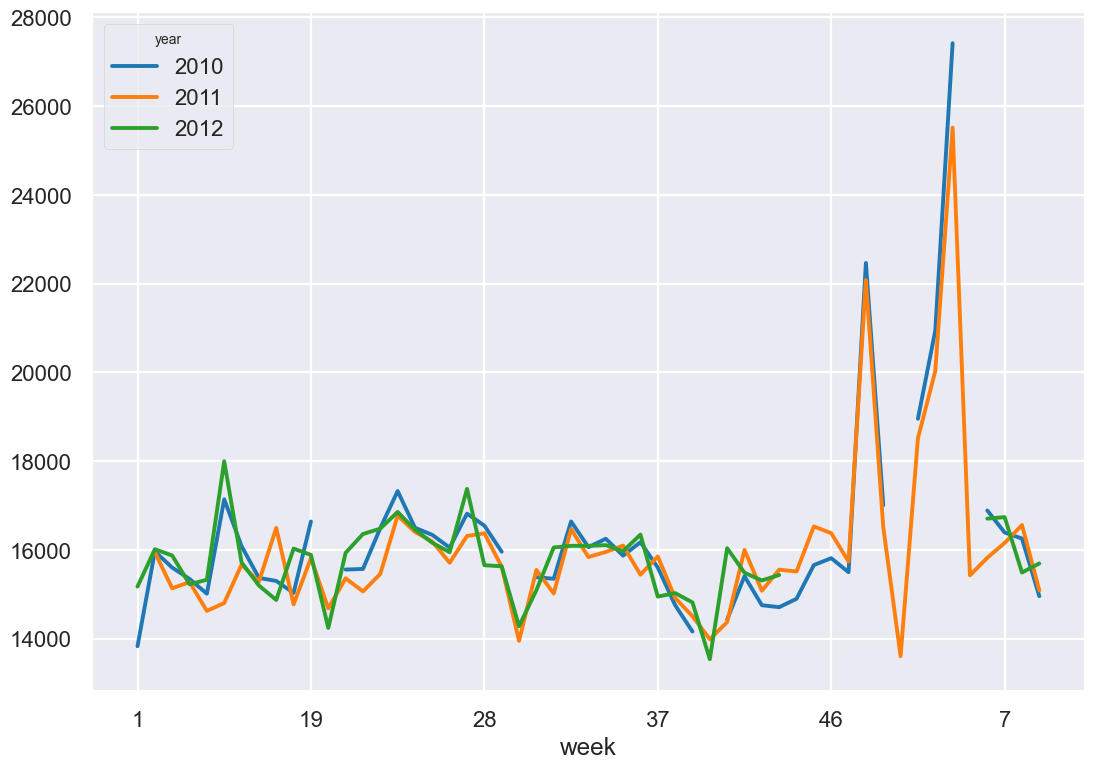

In [499]:
weekly_sales = pandas.pivot_table(df_test, values = "Weekly_Sales", columns = "year", index = "week")
weekly_sales.plot()

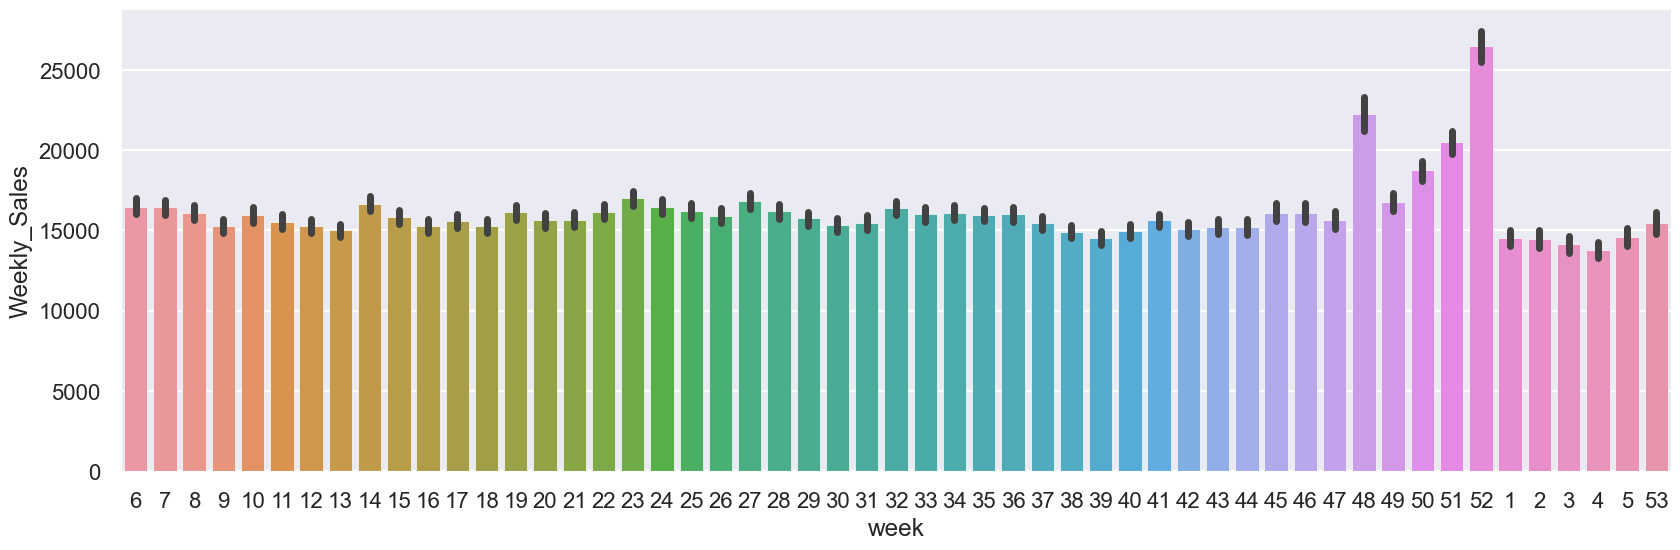

In [500]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='week', y='Weekly_Sales', data=df_test)

# Data Transformation

In [503]:
df_encoded = df

type_group = {'A': 1, 'B': 2, 'C': 3}

df_encoded = df_encoded.withColumn('Type', col('Type').cast('string'))
df_encoded = df_encoded.withColumn('Type', when(col('Type') == 'A', 1)
                                   .when(col('Type') == 'B', 2)
                                   .when(col('Type') == 'C', 3)
                                   .otherwise(col('Type').cast('int')))

bool_columns = ['Super_Bowl', 'Thanksgiving', 'Labor_Day', 'Christmas', 'IsHoliday']
for column in bool_columns:
    df_encoded = df_encoded.withColumn(column, col(column).cast('boolean').cast('int'))

df_new = df_encoded
df_new

Store,Date,Dept,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
1,2010-02-05,1,24924.5,1,151315,42.31,2.572,0,0,0,0,0,211.0963582,8.106,0,0,0,0,0,6,02,2010
1,2010-02-12,1,46039.49,1,151315,38.51,2.548,0,0,0,0,0,211.2421698,8.106,1,1,0,0,0,7,02,2010
1,2010-02-19,1,41595.55,1,151315,39.93,2.514,0,0,0,0,0,211.2891429,8.106,0,0,0,0,0,8,02,2010
1,2010-02-26,1,19403.54,1,151315,46.63,2.561,0,0,0,0,0,211.3196429,8.106,0,0,0,0,0,9,02,2010
1,2010-03-05,1,21827.9,1,151315,46.5,2.625,0,0,0,0,0,211.3501429,8.106,0,0,0,0,0,10,03,2010
1,2010-03-12,1,21043.39,1,151315,57.79,2.667,0,0,0,0,0,211.3806429,8.106,0,0,0,0,0,11,03,2010
1,2010-03-19,1,22136.64,1,151315,54.58,2.72,0,0,0,0,0,211.215635,8.106,0,0,0,0,0,12,03,2010
1,2010-03-26,1,26229.21,1,151315,51.45,2.732,0,0,0,0,0,211.0180424,8.106,0,0,0,0,0,13,03,2010
1,2010-04-02,1,57258.43,1,151315,62.27,2.719,0,0,0,0,0,210.8204499,7.808,0,0,0,0,0,14,04,2010
1,2010-04-09,1,42960.91,1,151315,65.86,2.77,0,0,0,0,0,210.6228574,7.808,0,0,0,0,0,15,04,2010


In [504]:
df

Store,Date,Dept,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
1,2010-02-05,1,24924.5,A,151315,42.31,2.572,0,0,0,0,0,211.0963582,8.106,false,false,false,false,false,6,02,2010
1,2010-02-12,1,46039.49,A,151315,38.51,2.548,0,0,0,0,0,211.2421698,8.106,true,true,false,false,false,7,02,2010
1,2010-02-19,1,41595.55,A,151315,39.93,2.514,0,0,0,0,0,211.2891429,8.106,false,false,false,false,false,8,02,2010
1,2010-02-26,1,19403.54,A,151315,46.63,2.561,0,0,0,0,0,211.3196429,8.106,false,false,false,false,false,9,02,2010
1,2010-03-05,1,21827.9,A,151315,46.5,2.625,0,0,0,0,0,211.3501429,8.106,false,false,false,false,false,10,03,2010
1,2010-03-12,1,21043.39,A,151315,57.79,2.667,0,0,0,0,0,211.3806429,8.106,false,false,false,false,false,11,03,2010
1,2010-03-19,1,22136.64,A,151315,54.58,2.72,0,0,0,0,0,211.215635,8.106,false,false,false,false,false,12,03,2010
1,2010-03-26,1,26229.21,A,151315,51.45,2.732,0,0,0,0,0,211.0180424,8.106,false,false,false,false,false,13,03,2010
1,2010-04-02,1,57258.43,A,151315,62.27,2.719,0,0,0,0,0,210.8204499,7.808,false,false,false,false,false,14,04,2010
1,2010-04-09,1,42960.91,A,151315,65.86,2.77,0,0,0,0,0,210.6228574,7.808,false,false,false,false,false,15,04,2010


In [505]:
df_new.write.csv("encoded.csv", header=True)

In [506]:
df.write.csv("iteration4cleandata.csv", header=True)

In [507]:
spark.stop()